Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 3.1) 와인 종류 분류하기

### 바로가기

- [1. Winequality 데이터 살펴보기](#1.-Winequality-데이터-살펴보기)
    - [Winequality 데이터셋의 기본 정보]
    - [데이터 전처리]
    - [피처의 분포 탐색]
- [2. 화이트와인과 레드와인 분류하기](#2.-화이트와인과-레드와인-분류하기)
    - [Logistic Regression]
    - [Decision Tree]
- [3. 와인의 등급 분류하기](#3.-와인의-등급-분류하기)
    - [멀티 레이블의 분류 방법]
    - [순위가 있는 레이블의 분류 방법]
    - [분류 모델의 평가]
- [4. 더 나은 결과를 위한 방법들](#4.-더-나은-결과를-위한-방법들)
    - [피처 엔지니어링]
    - [더 좋은 알고리즘 사용하기]
- [부록 : 선배의 Summary](#부록-:-선배의-Summary)

-----

In [209]:
# -*- coding: utf-8 -*-

%matplotlib inline

import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 1. Winequality 데이터 살펴보기

### [Winequality 데이터셋의 기본 정보]

In [210]:
# Data Source : https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

red_path = "../data/winequality-red.csv"
white_path = "../data/winequality-white.csv"

red_df = pd.read_csv(red_path, sep=";")
white_df = pd.read_csv(white_path, sep=";")

In [211]:
red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [212]:
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [213]:
print(red_df.shape)
print(white_df.shape)

(1599, 12)
(4898, 12)


-----

### [데이터 전처리]

##### 데이터 병합

In [214]:
# white = 1, red = 0
white_df['wine_kind'] = 1
red_df['wine_kind'] = 0

In [215]:
result_col = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
              'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
              'pH', 'sulphates', 'alcohol', 'quality', 'wine_kind']
df = pd.DataFrame(columns=result_col)
df = df.append(white_df)
df = df.append(red_df)
origin_df = df.copy()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_kind
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


-----

##### 피처 스케일링

In [216]:
pd.options.mode.chained_assignment = None

In [217]:
# 피처 각각에 대한 scaling을 수행합니다.
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)

In [218]:
scale_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                 'pH', 'sulphates', 'alcohol']
result = standard_scaling(df, scale_columns)

In [219]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_kind
0,-0.166076,-0.423150,0.284664,3.206682,-0.314951,0.815503,0.959902,2.102052,-1.358944,-0.546136,-1.418449,6,1
1,-0.706019,-0.240931,0.147035,-0.807775,-0.200775,-0.931035,0.287595,-0.232314,0.506876,-0.277330,-0.831551,6,1
2,0.682405,-0.362411,0.559923,0.306184,-0.172231,-0.029596,-0.331634,0.134515,0.258100,-0.613338,-0.328496,6,1
3,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181,6,1
4,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181,6,1


-----

### [피처의 분포 탐색]

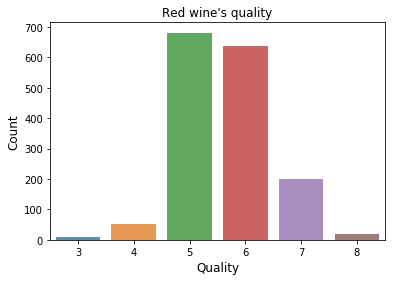

In [220]:
red_quality = df[df['wine_kind'] == 0]['quality'].value_counts().sort_index()

sns.barplot(red_quality.index, red_quality.values, alpha=0.8)
plt.title("Red wine's quality")
plt.ylabel("Count", fontsize=12)
plt.xlabel("Quality", fontsize=12)
plt.show()

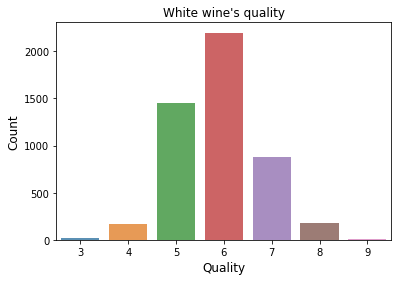

In [221]:
white_quality = df[df['wine_kind'] == 1]['quality'].value_counts().sort_index()

sns.barplot(white_quality.index, white_quality.values, alpha=0.8)
plt.title("White wine's quality")
plt.ylabel("Count", fontsize=12)
plt.xlabel("Quality", fontsize=12)
plt.show()

In [224]:
# 피처 각각에 대한 histogram을 그려줍니다.
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1)
    for i in range(len(df.columns)):
        ax = fig.add_subplot(4, 4, i+1)
        result = plt.hist(df[df.columns[i]], bins=100)
        ax.set_title(df.columns[i])
    plt.show()

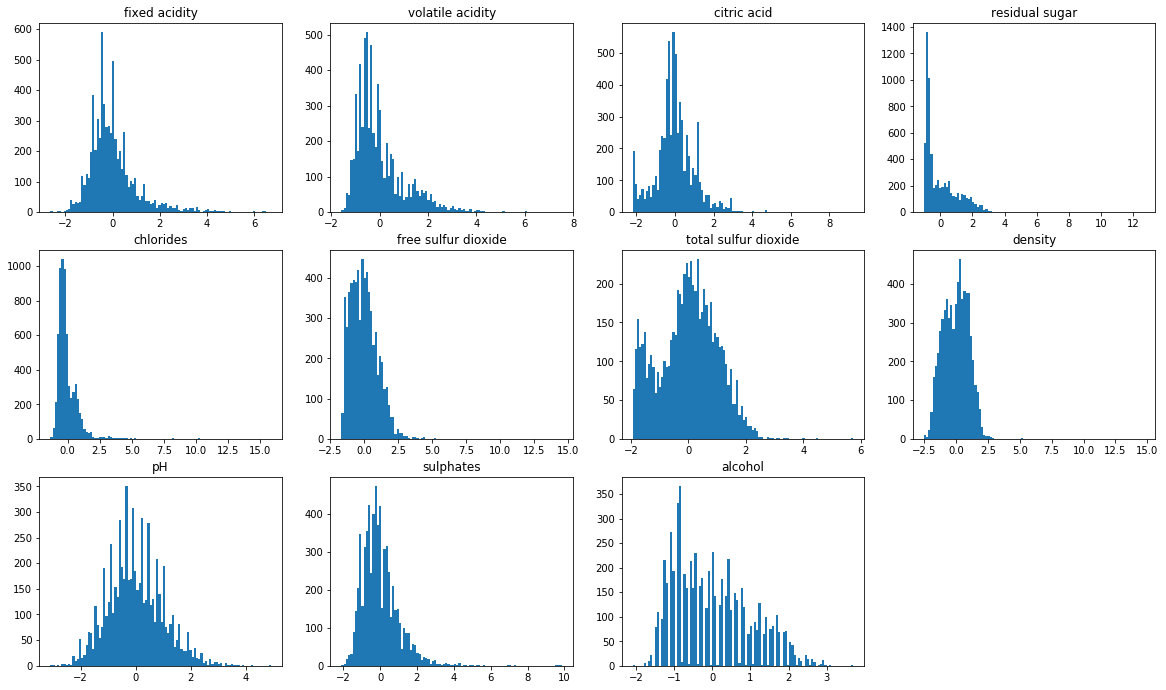

In [225]:
plot_hist_each_column(df[scale_columns])

-----

-----

# 5. 더 나은 결과를 위한 방법들

### [피처 엔지니어링]

##### 피처 분포 정상화

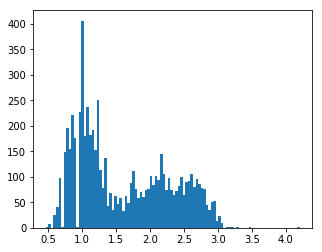

In [226]:
plt.rcParams['figure.figsize'] = [5, 4]
residual_sugar = origin_df['residual sugar'].apply(lambda x: math.log1p(x))
fig = plt.hist(residual_sugar, bins=100)

In [227]:
new_df = origin_df.copy()
new_df['residual sugar'] = new_df['residual sugar'].apply(lambda x: math.log1p(x))
result = standard_scaling(new_df, scale_columns)

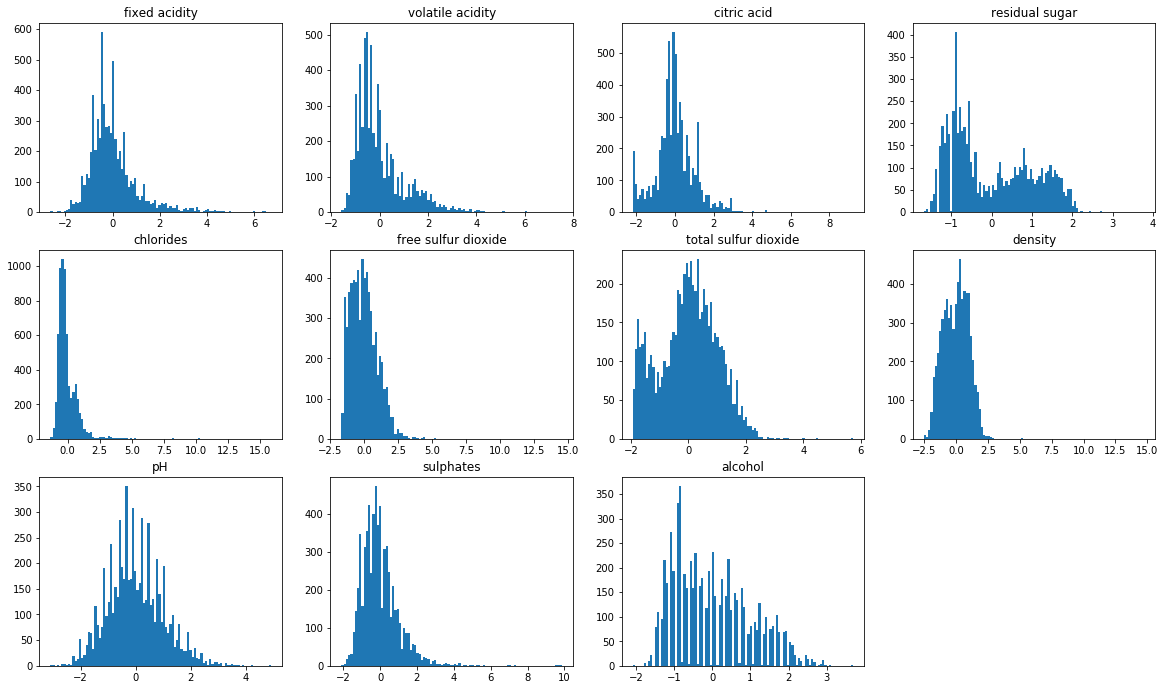

In [228]:
plot_hist_each_column(new_df[scale_columns])

-----

##### 이상치 제거

In [229]:
for col in scale_columns:
    new_df = new_df[abs(new_df[col]) < 5]

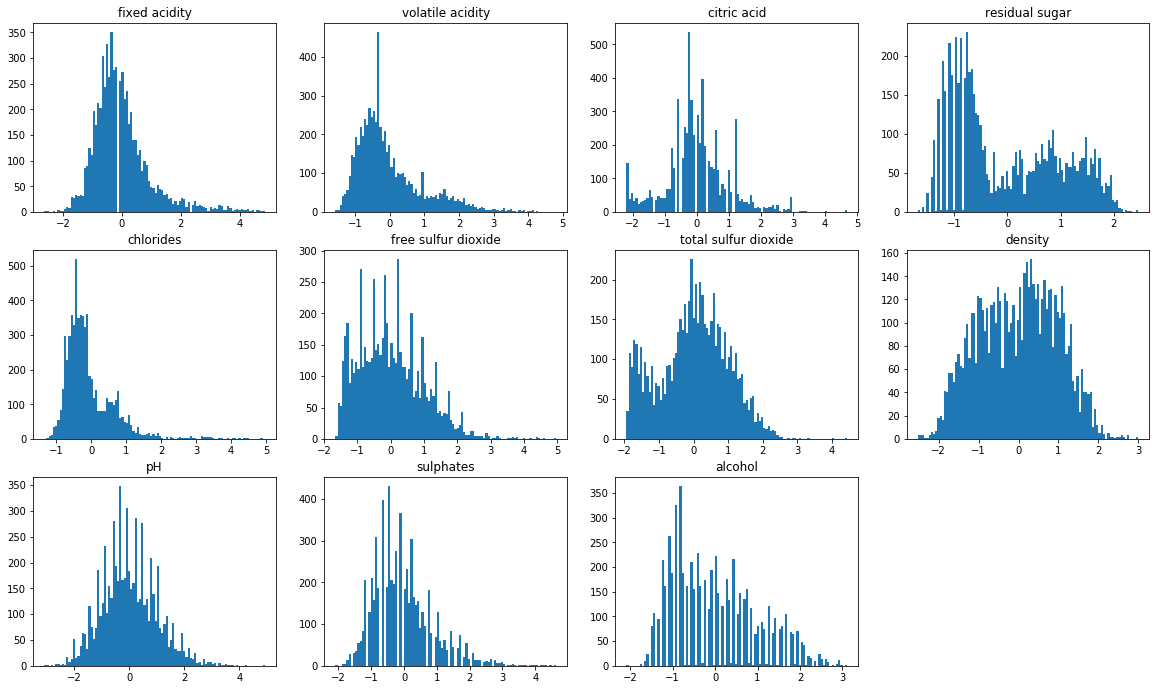

In [230]:
plot_hist_each_column(new_df[scale_columns])